In [1]:
import InputGenerator
import base_model
import keras
import pandas as pd
import numpy as np
import baseline_model
import importlib
import setGPU

Using TensorFlow backend.


setGPU: Setting GPU to: 0


/usr/local/lib64/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import InputBatchGenerator

In [3]:
import test_generator

In [4]:
importlib.reload(InputGenerator)

<module 'InputGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputGenerator.py'>

In [5]:
importlib.reload(InputBatchGenerator)

<module 'InputBatchGenerator' from '/nfshome/llayer/AIErrorLogAnalysis/training/InputBatchGenerator.py'>

In [4]:
gen = InputGenerator.InputGenerator('/nfshome/llayer/data/actionshistory_300719.json')

In [5]:
gen.set_labels()

In [8]:
gen.actionshistory.head()

,task_name,errors,parameters,action,action_binary_encoded,splitting,splitting_encoded,xrootd,xrootd_encoded,memory,memory_encoded,action_encoded,action_split,action_split_encoded,action_binary
0,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
1,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
2,/amaltaro_Run2016D-v2-DoubleMuonLowMass-07Aug1...,"{'good_sites': {}, 'bad_sites': {'-1': {'T3_US...","{'action': 'acdc', 'sites': ['T1_US_FNAL'], 'm...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc
3,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{'good_sites': {'85': {'T1_UK_RAL': 1}}, 'bad_...","{'action': 'acdc', 'cores': '', 'xrootd': 'ena...",acdc,0,1x,0,enabled,0,,3,0,acdc_1x,2,acdc
4,/amaltaro_Run2018A-v1-DoubleMuon-17Sep2018_102...,"{'good_sites': {'50664': {'T2_DE_RWTH': 2}, '-...","{'action': 'acdc', 'cores': '', 'sites': ['T2_...",acdc,0,1x,0,NaN,2,,3,0,acdc_1x,2,acdc


In [6]:
gen.set_padded_tokens()

In [7]:
gen.get_input_shape()

(33586, 77, 154, 200)

In [11]:
importlib.reload(test_generator)

<module 'test_generator' from '/nfshome/llayer/AIErrorLogAnalysis/training/test_generator.py'>

In [12]:
test_generator.test_count_matrix(gen, 2)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

In [10]:
import nlp_model

In [144]:
importlib.reload(nlp_model)

<module 'nlp_model' from '/nfshome/llayer/AIErrorLogAnalysis/training/nlp_model.py'>

In [67]:
importlib.reload(base_model)
importlib.reload(baseline_model)
importlib.reload(nlp_model) 
importlib.reload(InputBatchGenerator)

class FitHandler(object):
    
    def __init__(self, gen):
        
        self.gen = gen
        self.dim_tasks, self.dim_errors, self.dim_sites, self.dim_msg = gen.get_input_shape()
        self.sites =  gen.sites #gen.sites_to_tiers(gen.sites) # gen.sites
        self.codes = gen.codes
        #print (self.sites)
        
        
    def print_sample_summary(self, frame):
        
        print(frame.value_counts())
        
    
    def split_frame(self, label, split_level):
        
        train, test, _, _ = train_test_split(gen.actionshistory, gen.actionshistory[label], test_size=split_level)
        return train, test
        
    def k_fold_indices(self, kfold_function=KFold, kfold_splits=5, verbose=0):
        
        enum = enumerate(kfold_function(n_splits=kfold_splits, shuffle=True, random_state=seed).split(X,Y))
        if verbose != 0:
            enum = tqdm(enum, total=kfold_splits, desc='kfold', leave=False, initial=0)
        return enum
        
    def fit_base_model(self, label, batch_size = 100, test_split=0.2, val_split=0.2, verbose=0):
        
        
        # Split in train and test frames
        """
        train, test = self.split_frame(label, test_split)

        
        #self.print_sample_summary(train[label]) 
        #self.print_sample_summary(test[label]) 
        
        # Setup the generator of the input batches
        
        train_gen = InputBatchGenerator.InputBatchGenerator(train, label, self.codes, self.sites, self.dim_msg)
        test_gen = InputBatchGenerator.InputBatchGenerator(test, label, self.codes, self.sites, self.dim_msg)        
        X_train, y_train = train_gen.count_matrix(sum_good_bad = True)
        X_test, y_test = test_gen.count_matrix(sum_good_bad = True)
        
        print(type(y_test))
        
        print(X_train.shape)
        print(X_test.shape)
        #print(np.unique(y_train), return_counts = True)
        #print(np.unique(y_test), return_counts = True)
        
        uniqueValues, occurCount = np.unique(y_test, return_counts=True)
        print(uniqueValues, occurCount)
        # Set the baseline model
        n_sites = len(list(set(self.sites.values())))
        """
        cv_gen = InputBatchGenerator.InputBatchGenerator(gen.actionshistory, label, self.codes, self.sites, self.dim_msg)
        X, y = cv_gen.count_matrix(sum_good_bad = True)
        
        model = baseline_model.FF(2, self.dim_errors, self.dim_sites)
        
        #cv_score = model.kfold_val(X, y, kfold_splits=5, max_epochs = 200, batch_size = 100, early_stopping = True)
        
        #return cv_score
        #history = model.train(X_train, y_train, X_test, y_test, max_epochs = 200, batch_size = 100, early_stopping = True)
        
        #return history
        
        
        model.find_optimal_parameters(X, y, 5, max_epochs = 100, batch_size = 100, num_calls=20)

        
    def fit_nlp_model(self, label, batch_size = 1, test_split=0.2, val_split=0.2, verbose=1):

        # Set the baseline model
        model = nlp_model.NLP_Model(2, self.dim_errors, self.dim_sites, self.dim_msg)            
        #model.print_summary()
        
        # Split in train and test frames
        train, test = self.split_frame(label, test_split)
        
        # Setup the generator of the input batches
        train_gen = InputBatchGenerator.InputBatchGenerator(train, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg)
        test_gen = InputBatchGenerator.InputBatchGenerator(test, label, \
                                                            batch_size, self.codes, self.sites, self.dim_msg) 
        
        """
        for x,y in train_gen.gen_inf_count_msg_batches():
            print( x[0].shape )
        """
        
        steps_per_epoch = int(float(len(train)) / float(batch_size))
        validation_steps = int(float(len(test)) / float(batch_size))
        
        model.train_on_batch(training_generator = train_gen, validation_generator = test_gen, 
                             epochs = 1, steps_per_epoch = steps_per_epoch, validation_steps = validation_steps )
        
        

In [68]:
handler = FitHandler(gen)

In [69]:
history = handler.fit_base_model('action_binary_encoded', verbose=1)


 	 ::: 1 SKOPT CALL ::: 

{'learning_rate': 0.001, 'dense_units': 20, 'dense_layers': 3}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        (None, 77, 154)           0         
_________________________________________________________________
flatten_98 (Flatten)         (None, 11858)             0         
_________________________________________________________________
dense_389 (Dense)            (None, 20)                237180    
_________________________________________________________________
dropout_292 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_390 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_293 (Dropout)        (None, 20)                0         
_________________________________

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 15s 559us/step - loss: 0.3564 - acc: 0.9485 - val_loss: 0.2708 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2357 - acc: 0.9488 - val_loss: 0.2515 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2217 - acc: 0.9488 - val_loss: 0.2513 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 132us/step - loss: 0.2124 - acc: 0.9487 - val_loss: 0.2421 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 137us/step - loss: 0.2096 - acc: 0.9487 - val_loss: 0.2453 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2056 - acc: 0.9488 - val_loss: 0.2365 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2037 - acc: 0.9487 - val_loss: 0.

Epoch 7/200
26869/26869 [==============================] - 4s 133us/step - loss: 0.2042 - acc: 0.9487 - val_loss: 0.2461 - val_acc: 0.9446
Epoch 8/200
26869/26869 [==============================] - 3s 119us/step - loss: 0.2025 - acc: 0.9483 - val_loss: 0.2437 - val_acc: 0.9449
Epoch 9/200
26869/26869 [==============================] - 3s 117us/step - loss: 0.2019 - acc: 0.9488 - val_loss: 0.2399 - val_acc: 0.9449
Epoch 10/200
26869/26869 [==============================] - 3s 119us/step - loss: 0.2006 - acc: 0.9485 - val_loss: 0.2441 - val_acc: 0.9451
Epoch 11/200
26869/26869 [==============================] - 4s 136us/step - loss: 0.2023 - acc: 0.9488 - val_loss: 0.2478 - val_acc: 0.9449
Epoch 12/200
26869/26869 [==============================] - 3s 109us/step - loss: 0.2000 - acc: 0.9487 - val_loss: 0.2435 - val_acc: 0.9449
Epoch 13/200
26869/26869 [==============================] - 3s 111us/step - loss: 0.2019 - acc: 0.9487 - val_loss: 0.2394 - val_acc: 0.9448
Epoch 14/200
26869/2686

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 16s 592us/step - loss: 0.2420 - acc: 0.9472 - val_loss: 0.2077 - val_acc: 0.9476
Epoch 2/200
26869/26869 [==============================] - 4s 143us/step - loss: 0.2074 - acc: 0.9481 - val_loss: 0.2067 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 4s 148us/step - loss: 0.2073 - acc: 0.9481 - val_loss: 0.2064 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 4s 140us/step - loss: 0.2055 - acc: 0.9481 - val_loss: 0.2081 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 4s 136us/step - loss: 0.2063 - acc: 0.9481 - val_loss: 0.2079 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 4s 136us/step - loss: 0.2068 - acc: 0.9481 - val_loss: 0.2116 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 4s 147us/step - loss: 0.2049 - acc: 0.9481 - val_loss: 0.

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 16s 598us/step - loss: 0.2421 - acc: 0.9462 - val_loss: 0.1953 - val_acc: 0.9534
Epoch 2/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2107 - acc: 0.9466 - val_loss: 0.1895 - val_acc: 0.9534
Epoch 3/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2113 - acc: 0.9466 - val_loss: 0.1942 - val_acc: 0.9534
Epoch 4/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2105 - acc: 0.9466 - val_loss: 0.1891 - val_acc: 0.9534
Epoch 5/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2103 - acc: 0.9466 - val_loss: 0.1925 - val_acc: 0.9534
Epoch 6/200
26869/26869 [==============================] - 3s 126us/step - loss: 0.2107 - acc: 0.9466 - val_loss: 0.1891 - val_acc: 0.9534
Epoch 7/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2089 - acc: 0.9466 - val_loss: 0.

Epoch 8/200
26868/26868 [==============================] - 3s 117us/step - loss: 0.2154 - acc: 0.9477 - val_loss: 0.2138 - val_acc: 0.9491
Epoch 9/200
26868/26868 [==============================] - 3s 113us/step - loss: 0.2191 - acc: 0.9477 - val_loss: 0.2169 - val_acc: 0.9491
Epoch 10/200
26868/26868 [==============================] - 3s 114us/step - loss: 0.2164 - acc: 0.9477 - val_loss: 0.2149 - val_acc: 0.9491
Epoch 11/200
26868/26868 [==============================] - 3s 114us/step - loss: 0.2184 - acc: 0.9477 - val_loss: 0.2168 - val_acc: 0.9491
Epoch 12/200
26868/26868 [==============================] - 3s 112us/step - loss: 0.2147 - acc: 0.9477 - val_loss: 0.2157 - val_acc: 0.9491
Epoch 00012: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________

26869/26869 [==============================] - 3s 129us/step - loss: 0.2122 - acc: 0.9488 - val_loss: 0.2293 - val_acc: 0.9449
Epoch 13/200
26869/26869 [==============================] - 3s 128us/step - loss: 0.2105 - acc: 0.9488 - val_loss: 0.2320 - val_acc: 0.9449
Epoch 14/200
26869/26869 [==============================] - 3s 128us/step - loss: 0.2130 - acc: 0.9488 - val_loss: 0.2299 - val_acc: 0.9449
Epoch 15/200
26869/26869 [==============================] - 4s 134us/step - loss: 0.2150 - acc: 0.9488 - val_loss: 0.2341 - val_acc: 0.9449
Epoch 16/200
26869/26869 [==============================] - 4s 139us/step - loss: 0.2130 - acc: 0.9488 - val_loss: 0.2266 - val_acc: 0.9449
Epoch 17/200
26869/26869 [==============================] - 4s 141us/step - loss: 0.2084 - acc: 0.9488 - val_loss: 0.2277 - val_acc: 0.9449
Epoch 18/200
26869/26869 [==============================] - 3s 129us/step - loss: 0.2112 - acc: 0.9488 - val_loss: 0.2280 - val_acc: 0.9449
Epoch 19/200
26869/26869 [=======

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 19s 720us/step - loss: 0.3008 - acc: 0.9474 - val_loss: 0.2518 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 3s 128us/step - loss: 0.2367 - acc: 0.9488 - val_loss: 0.2424 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 3s 117us/step - loss: 0.2257 - acc: 0.9486 - val_loss: 0.2448 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 3s 116us/step - loss: 0.2274 - acc: 0.9488 - val_loss: 0.2410 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 3s 125us/step - loss: 0.2254 - acc: 0.9488 - val_loss: 0.2404 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 3s 126us/step - loss: 0.2254 - acc: 0.9488 - val_loss: 0.2377 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 3s 126us/step - loss: 0.2255 - acc: 0.9487 - val_loss: 0.

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 20s 738us/step - loss: 0.3018 - acc: 0.9457 - val_loss: 0.2549 - val_acc: 0.9474
Epoch 2/200
26869/26869 [==============================] - 4s 131us/step - loss: 0.2567 - acc: 0.9479 - val_loss: 0.2594 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 4s 130us/step - loss: 0.2378 - acc: 0.9481 - val_loss: 0.2383 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 4s 134us/step - loss: 0.2325 - acc: 0.9481 - val_loss: 0.2600 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 4s 134us/step - loss: 0.2406 - acc: 0.9481 - val_loss: 0.2293 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2222 - acc: 0.9481 - val_loss: 0.2256 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 4s 143us/step - loss: 0.2292 - acc: 0.9481 - val_loss: 0.

26869/26869 [==============================] - 4s 143us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.2134 - val_acc: 0.9449
Epoch 22/200
26869/26869 [==============================] - 4s 138us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.2137 - val_acc: 0.9449
Epoch 23/200
26869/26869 [==============================] - 4s 139us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.2134 - val_acc: 0.9449
Epoch 24/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.2137 - val_acc: 0.9449
Epoch 25/200
26869/26869 [==============================] - 4s 134us/step - loss: 0.2023 - acc: 0.9488 - val_loss: 0.2133 - val_acc: 0.9449
Epoch 26/200
26869/26869 [==============================] - 4s 133us/step - loss: 0.2025 - acc: 0.9488 - val_loss: 0.2135 - val_acc: 0.9449
Epoch 27/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2024 - acc: 0.9488 - val_loss: 0.2140 - val_acc: 0.9449
Epoch 28/200
26869/26869 [=======

-0.5341429137463931 0.041975311582327195

 	 ::: 5 SKOPT CALL ::: 

{'learning_rate': 0.09793225376881949, 'dense_units': 32, 'dense_layers': 2}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_118 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_118 (Flatten)        (None, 11858)             0         
_________________________________________________________________
dense_484 (Dense)            (None, 32)                379488    
_________________________________________________________________
dropout_367 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_485 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_368 (Dropout)        (None, 32)     

Epoch 15/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2084 - acc: 0.9481 - val_loss: 0.2114 - val_acc: 0.9476
Epoch 16/200
26869/26869 [==============================] - 4s 157us/step - loss: 0.2122 - acc: 0.9481 - val_loss: 0.2264 - val_acc: 0.9476
Epoch 17/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2101 - acc: 0.9481 - val_loss: 0.2084 - val_acc: 0.9476
Epoch 18/200
26869/26869 [==============================] - 3s 123us/step - loss: 0.2081 - acc: 0.9481 - val_loss: 0.2125 - val_acc: 0.9476
Epoch 19/200
26869/26869 [==============================] - 4s 133us/step - loss: 0.2114 - acc: 0.9481 - val_loss: 0.2071 - val_acc: 0.9476
Epoch 20/200
26869/26869 [==============================] - 3s 126us/step - loss: 0.2069 - acc: 0.9481 - val_loss: 0.2115 - val_acc: 0.9476
Epoch 21/200
26869/26869 [==============================] - 4s 132us/step - loss: 0.2114 - acc: 0.9481 - val_loss: 0.2071 - val_acc: 0.9476
Epoch 22/200
26869/2

Epoch 10/200
26869/26869 [==============================] - 3s 122us/step - loss: 0.2112 - acc: 0.9466 - val_loss: 0.1956 - val_acc: 0.9534
Epoch 11/200
26869/26869 [==============================] - 3s 122us/step - loss: 0.2192 - acc: 0.9466 - val_loss: 0.1895 - val_acc: 0.9534
Epoch 12/200
26869/26869 [==============================] - 3s 123us/step - loss: 0.2096 - acc: 0.9466 - val_loss: 0.1893 - val_acc: 0.9534
Epoch 13/200
26869/26869 [==============================] - 3s 121us/step - loss: 0.2110 - acc: 0.9466 - val_loss: 0.1962 - val_acc: 0.9534
Epoch 14/200
26869/26869 [==============================] - 3s 120us/step - loss: 0.2170 - acc: 0.9466 - val_loss: 0.1900 - val_acc: 0.9534
Epoch 15/200
26869/26869 [==============================] - 3s 121us/step - loss: 0.2096 - acc: 0.9466 - val_loss: 0.1897 - val_acc: 0.9534
Epoch 16/200
26869/26869 [==============================] - 3s 124us/step - loss: 0.2141 - acc: 0.9466 - val_loss: 0.2083 - val_acc: 0.9534
Epoch 17/200
26869/2

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 19s 707us/step - loss: 0.3151 - acc: 0.9474 - val_loss: 0.2175 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 4s 156us/step - loss: 0.2217 - acc: 0.9477 - val_loss: 0.2106 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 5s 171us/step - loss: 0.2153 - acc: 0.9477 - val_loss: 0.2102 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 4s 154us/step - loss: 0.2100 - acc: 0.9477 - val_loss: 0.2037 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 4s 148us/step - loss: 0.2083 - acc: 0.9477 - val_loss: 0.2030 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 4s 146us/step - loss: 0.2079 - acc: 0.9477 - val_loss: 0.2027 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 147us/step - loss: 0.2073 - acc: 0.9477 - val_loss: 0.

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 19s 708us/step - loss: 0.3149 - acc: 0.9474 - val_loss: 0.2263 - val_acc: 0.9476
Epoch 2/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2180 - acc: 0.9481 - val_loss: 0.2172 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 4s 147us/step - loss: 0.2104 - acc: 0.9481 - val_loss: 0.2090 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 4s 153us/step - loss: 0.2080 - acc: 0.9481 - val_loss: 0.2086 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2070 - acc: 0.9481 - val_loss: 0.2105 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 4s 148us/step - loss: 0.2064 - acc: 0.9481 - val_loss: 0.2073 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 4s 149us/step - loss: 0.2058 - acc: 0.9481 - val_loss: 0.

Epoch 4/200
26869/26869 [==============================] - 4s 147us/step - loss: 0.2052 - acc: 0.9488 - val_loss: 0.2160 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 151us/step - loss: 0.2052 - acc: 0.9488 - val_loss: 0.2149 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2045 - acc: 0.9488 - val_loss: 0.2151 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 141us/step - loss: 0.2046 - acc: 0.9488 - val_loss: 0.2144 - val_acc: 0.9449
Epoch 8/200
26869/26869 [==============================] - 4s 141us/step - loss: 0.2042 - acc: 0.9488 - val_loss: 0.2148 - val_acc: 0.9449
Epoch 9/200
26869/26869 [==============================] - 4s 143us/step - loss: 0.2039 - acc: 0.9488 - val_loss: 0.2142 - val_acc: 0.9449
Epoch 10/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2039 - acc: 0.9488 - val_loss: 0.2143 - val_acc: 0.9449
Epoch 11/200
26869/26869 [

26869/26869 [==============================] - 4s 139us/step - loss: 0.2092 - acc: 0.9466 - val_loss: 0.1890 - val_acc: 0.9534
Epoch 30/200
26869/26869 [==============================] - 4s 146us/step - loss: 0.2091 - acc: 0.9466 - val_loss: 0.1891 - val_acc: 0.9534
Epoch 31/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2092 - acc: 0.9466 - val_loss: 0.1908 - val_acc: 0.9534
Epoch 32/200
26869/26869 [==============================] - 4s 153us/step - loss: 0.2093 - acc: 0.9466 - val_loss: 0.1888 - val_acc: 0.9534
Epoch 33/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2092 - acc: 0.9466 - val_loss: 0.1888 - val_acc: 0.9534
Epoch 34/200
26869/26869 [==============================] - 4s 141us/step - loss: 0.2089 - acc: 0.9466 - val_loss: 0.1891 - val_acc: 0.9534
Epoch 35/200
26869/26869 [==============================] - 4s 138us/step - loss: 0.2091 - acc: 0.9466 - val_loss: 0.1895 - val_acc: 0.9534
Epoch 36/200
26869/26869 [=======

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 19s 719us/step - loss: 0.7298 - acc: 0.9434 - val_loss: 0.2788 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 4s 136us/step - loss: 0.2353 - acc: 0.9477 - val_loss: 0.2096 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 4s 138us/step - loss: 0.2095 - acc: 0.9477 - val_loss: 0.2027 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 4s 155us/step - loss: 0.2073 - acc: 0.9477 - val_loss: 0.2028 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 4s 147us/step - loss: 0.2071 - acc: 0.9477 - val_loss: 0.2034 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 4s 144us/step - loss: 0.2106 - acc: 0.9477 - val_loss: 0.2164 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 135us/step - loss: 0.2268 - acc: 0.9477 - val_loss: 0.

26869/26869 [==============================] - 4s 148us/step - loss: 0.2034 - acc: 0.9488 - val_loss: 0.2145 - val_acc: 0.9449
Epoch 9/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2041 - acc: 0.9488 - val_loss: 0.2158 - val_acc: 0.9449
Epoch 10/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2088 - acc: 0.9488 - val_loss: 0.2279 - val_acc: 0.9449
Epoch 11/200
26869/26869 [==============================] - 4s 141us/step - loss: 0.2152 - acc: 0.9488 - val_loss: 0.2149 - val_acc: 0.9449
Epoch 12/200
26869/26869 [==============================] - 4s 145us/step - loss: 0.2039 - acc: 0.9488 - val_loss: 0.2161 - val_acc: 0.9449
Epoch 00012: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_131 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
fla

26869/26869 [==============================] - 4s 154us/step - loss: 0.2085 - acc: 0.9488 - val_loss: 0.2279 - val_acc: 0.9449
Epoch 11/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2154 - acc: 0.9488 - val_loss: 0.2174 - val_acc: 0.9449
Epoch 12/200
26869/26869 [==============================] - 4s 153us/step - loss: 0.2041 - acc: 0.9488 - val_loss: 0.2147 - val_acc: 0.9449
Epoch 00012: early stopping
-0.4999373062118293 7.697287216252554e-05

 	 ::: 8 SKOPT CALL ::: 

{'learning_rate': 0.015320204284174802, 'dense_units': 20, 'dense_layers': 4}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_133 (Flatten)        (None, 11858)             0         
_________________________________________________________________
den

26869/26869 [==============================] - 4s 135us/step - loss: 0.2052 - acc: 0.9481 - val_loss: 0.2059 - val_acc: 0.9476
Epoch 14/200
26869/26869 [==============================] - 4s 140us/step - loss: 0.2050 - acc: 0.9481 - val_loss: 0.2058 - val_acc: 0.9476
Epoch 15/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2048 - acc: 0.9481 - val_loss: 0.2057 - val_acc: 0.9476
Epoch 16/200
26869/26869 [==============================] - 4s 137us/step - loss: 0.2046 - acc: 0.9481 - val_loss: 0.2057 - val_acc: 0.9476
Epoch 17/200
26869/26869 [==============================] - 4s 140us/step - loss: 0.2048 - acc: 0.9481 - val_loss: 0.2070 - val_acc: 0.9476
Epoch 18/200
26869/26869 [==============================] - 4s 134us/step - loss: 0.2045 - acc: 0.9481 - val_loss: 0.2061 - val_acc: 0.9476
Epoch 19/200
26869/26869 [==============================] - 4s 132us/step - loss: 0.2044 - acc: 0.9481 - val_loss: 0.2058 - val_acc: 0.9476
Epoch 20/200
26869/26869 [=======

26869/26869 [==============================] - 3s 129us/step - loss: 0.2095 - acc: 0.9466 - val_loss: 0.1899 - val_acc: 0.9534
Epoch 11/200
26869/26869 [==============================] - 4s 133us/step - loss: 0.2098 - acc: 0.9466 - val_loss: 0.1890 - val_acc: 0.9534
Epoch 12/200
26869/26869 [==============================] - 4s 133us/step - loss: 0.2090 - acc: 0.9466 - val_loss: 0.1890 - val_acc: 0.9534
Epoch 13/200
26869/26869 [==============================] - 4s 136us/step - loss: 0.2093 - acc: 0.9466 - val_loss: 0.1887 - val_acc: 0.9534
Epoch 14/200
26869/26869 [==============================] - 4s 137us/step - loss: 0.2088 - acc: 0.9466 - val_loss: 0.1917 - val_acc: 0.9534
Epoch 15/200
26869/26869 [==============================] - 3s 129us/step - loss: 0.2089 - acc: 0.9466 - val_loss: 0.1889 - val_acc: 0.9534
Epoch 16/200
26869/26869 [==============================] - 3s 129us/step - loss: 0.2090 - acc: 0.9466 - val_loss: 0.1893 - val_acc: 0.9534
Epoch 17/200
26869/26869 [=======

26868/26868 [==============================] - 21s 783us/step - loss: 0.2474 - acc: 0.9453 - val_loss: 0.2047 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 4s 134us/step - loss: 0.2095 - acc: 0.9477 - val_loss: 0.2024 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 4s 138us/step - loss: 0.2070 - acc: 0.9477 - val_loss: 0.2028 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 4s 133us/step - loss: 0.2070 - acc: 0.9477 - val_loss: 0.2027 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 3s 130us/step - loss: 0.2072 - acc: 0.9477 - val_loss: 0.2034 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 4s 135us/step - loss: 0.2071 - acc: 0.9477 - val_loss: 0.2018 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 136us/step - loss: 0.2057 - acc: 0.9477 - val_loss: 0.2020 - val_acc: 0.9491
Epoch 8/200
26868/26868 [=============

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 24s 895us/step - loss: 0.2404 - acc: 0.9458 - val_loss: 0.2161 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 4s 145us/step - loss: 0.2047 - acc: 0.9488 - val_loss: 0.2149 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 4s 143us/step - loss: 0.2049 - acc: 0.9488 - val_loss: 0.2151 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2038 - acc: 0.9488 - val_loss: 0.2149 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 160us/step - loss: 0.2037 - acc: 0.9488 - val_loss: 0.2157 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 158us/step - loss: 0.2044 - acc: 0.9488 - val_loss: 0.2151 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 152us/step - loss: 0.2029 - acc: 0.9488 - val_loss: 0.

26869/26869 [==============================] - 22s 802us/step - loss: 0.2417 - acc: 0.9469 - val_loss: 0.2171 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 4s 153us/step - loss: 0.2045 - acc: 0.9488 - val_loss: 0.2153 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 4s 136us/step - loss: 0.2038 - acc: 0.9488 - val_loss: 0.2141 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 137us/step - loss: 0.2043 - acc: 0.9488 - val_loss: 0.2137 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 138us/step - loss: 0.2041 - acc: 0.9488 - val_loss: 0.2146 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 138us/step - loss: 0.2040 - acc: 0.9488 - val_loss: 0.2135 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2029 - acc: 0.9488 - val_loss: 0.2144 - val_acc: 0.9449
Epoch 8/200
26869/26869 [=============

26869/26869 [==============================] - 4s 144us/step - loss: 0.2162 - acc: 0.9481 - val_loss: 0.2238 - val_acc: 0.9476
Epoch 9/200
26869/26869 [==============================] - 4s 152us/step - loss: 0.2149 - acc: 0.9480 - val_loss: 0.2261 - val_acc: 0.9476
Epoch 10/200
26869/26869 [==============================] - 4s 148us/step - loss: 0.2138 - acc: 0.9481 - val_loss: 0.2133 - val_acc: 0.9476
Epoch 11/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2115 - acc: 0.9481 - val_loss: 0.2177 - val_acc: 0.9476
Epoch 12/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2145 - acc: 0.9481 - val_loss: 0.2223 - val_acc: 0.9476
Epoch 13/200
26869/26869 [==============================] - 4s 154us/step - loss: 0.2174 - acc: 0.9481 - val_loss: 0.2156 - val_acc: 0.9476
Epoch 14/200
26869/26869 [==============================] - 4s 142us/step - loss: 0.2141 - acc: 0.9481 - val_loss: 0.2222 - val_acc: 0.9476
Epoch 15/200
26869/26869 [========

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 23s 846us/step - loss: 0.3129 - acc: 0.9431 - val_loss: 0.2302 - val_acc: 0.9534
Epoch 2/200
26869/26869 [==============================] - 4s 146us/step - loss: 0.2389 - acc: 0.9464 - val_loss: 0.2203 - val_acc: 0.9534
Epoch 3/200
26869/26869 [==============================] - 4s 146us/step - loss: 0.2303 - acc: 0.9466 - val_loss: 0.2170 - val_acc: 0.9534
Epoch 4/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2242 - acc: 0.9466 - val_loss: 0.2189 - val_acc: 0.9533
Epoch 5/200
26869/26869 [==============================] - 4s 145us/step - loss: 0.2236 - acc: 0.9466 - val_loss: 0.2183 - val_acc: 0.9534
Epoch 6/200
26869/26869 [==============================] - 4s 146us/step - loss: 0.2220 - acc: 0.9466 - val_loss: 0.2116 - val_acc: 0.9534
Epoch 7/200
26869/26869 [==============================] - 4s 149us/step - loss: 0.2214 - acc: 0.9466 - val_loss: 0.

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 23s 874us/step - loss: 0.2537 - acc: 0.9477 - val_loss: 0.2152 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 4s 144us/step - loss: 0.2105 - acc: 0.9477 - val_loss: 0.2041 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 4s 147us/step - loss: 0.2076 - acc: 0.9477 - val_loss: 0.2021 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 4s 144us/step - loss: 0.2068 - acc: 0.9477 - val_loss: 0.2025 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 4s 147us/step - loss: 0.2066 - acc: 0.9477 - val_loss: 0.2026 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 4s 146us/step - loss: 0.2067 - acc: 0.9477 - val_loss: 0.2020 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 146us/step - loss: 0.2063 - acc: 0.9477 - val_loss: 0.

Epoch 2/200
26869/26869 [==============================] - 4s 143us/step - loss: 0.2152 - acc: 0.9488 - val_loss: 0.2215 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 4s 152us/step - loss: 0.2058 - acc: 0.9488 - val_loss: 0.2194 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 154us/step - loss: 0.2045 - acc: 0.9488 - val_loss: 0.2140 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 144us/step - loss: 0.2035 - acc: 0.9488 - val_loss: 0.2161 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 145us/step - loss: 0.2036 - acc: 0.9488 - val_loss: 0.2135 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 147us/step - loss: 0.2032 - acc: 0.9488 - val_loss: 0.2142 - val_acc: 0.9449
Epoch 8/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2031 - acc: 0.9488 - val_loss: 0.2136 - val_acc: 0.9449
Epoch 9/200
26869/26869 [==

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 24s 877us/step - loss: 0.2640 - acc: 0.9481 - val_loss: 0.2309 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 5s 176us/step - loss: 0.2140 - acc: 0.9488 - val_loss: 0.2180 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 5s 183us/step - loss: 0.2053 - acc: 0.9488 - val_loss: 0.2144 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 5s 191us/step - loss: 0.2040 - acc: 0.9488 - val_loss: 0.2138 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2037 - acc: 0.9488 - val_loss: 0.2164 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 159us/step - loss: 0.2035 - acc: 0.9488 - val_loss: 0.2160 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 157us/step - loss: 0.2030 - acc: 0.9488 - val_loss: 0.

26869/26869 [==============================] - 5s 170us/step - loss: 0.1973 - acc: 0.9481 - val_loss: 0.2101 - val_acc: 0.9476
Epoch 12/200
26869/26869 [==============================] - 4s 156us/step - loss: 0.1984 - acc: 0.9481 - val_loss: 0.2126 - val_acc: 0.9476
Epoch 13/200
26869/26869 [==============================] - 5s 178us/step - loss: 0.1966 - acc: 0.9482 - val_loss: 0.2117 - val_acc: 0.9477
Epoch 14/200
26869/26869 [==============================] - 4s 162us/step - loss: 0.1975 - acc: 0.9481 - val_loss: 0.2103 - val_acc: 0.9477
Epoch 15/200
26869/26869 [==============================] - 4s 147us/step - loss: 0.1969 - acc: 0.9481 - val_loss: 0.2077 - val_acc: 0.9474
Epoch 16/200
26869/26869 [==============================] - 5s 184us/step - loss: 0.1976 - acc: 0.9480 - val_loss: 0.2093 - val_acc: 0.9476
Epoch 17/200
26869/26869 [==============================] - 5s 171us/step - loss: 0.1970 - acc: 0.9482 - val_loss: 0.2108 - val_acc: 0.9479
Epoch 18/200
26869/26869 [=======

Epoch 16/200
26869/26869 [==============================] - 5s 177us/step - loss: 0.2064 - acc: 0.9466 - val_loss: 0.2064 - val_acc: 0.9534
Epoch 17/200
26869/26869 [==============================] - 4s 150us/step - loss: 0.2052 - acc: 0.9466 - val_loss: 0.2031 - val_acc: 0.9534
Epoch 00017: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_157 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_157 (Flatten)        (None, 11858)             0         
_________________________________________________________________
dense_676 (Dense)            (None, 10)                118590    
_________________________________________________________________
dropout_520 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_677 (De

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 29s 1ms/step - loss: 0.3040 - acc: 0.9464 - val_loss: 0.2491 - val_acc: 0.9476
Epoch 2/200
26869/26869 [==============================] - 5s 177us/step - loss: 0.2441 - acc: 0.9480 - val_loss: 0.2357 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 4s 146us/step - loss: 0.2371 - acc: 0.9481 - val_loss: 0.2375 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 4s 161us/step - loss: 0.2326 - acc: 0.9480 - val_loss: 0.2372 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 5s 172us/step - loss: 0.2286 - acc: 0.9480 - val_loss: 0.2375 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 5s 169us/step - loss: 0.2277 - acc: 0.9481 - val_loss: 0.2265 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 5s 174us/step - loss: 0.2218 - acc: 0.9481 - val_loss: 0.22

26869/26869 [==============================] - 4s 164us/step - loss: 0.2035 - acc: 0.9488 - val_loss: 0.2252 - val_acc: 0.9449
Epoch 30/200
26869/26869 [==============================] - 5s 174us/step - loss: 0.2034 - acc: 0.9487 - val_loss: 0.2262 - val_acc: 0.9449
Epoch 31/200
26869/26869 [==============================] - 5s 178us/step - loss: 0.2058 - acc: 0.9487 - val_loss: 0.2254 - val_acc: 0.9449
Epoch 00031: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_161 (Flatten)        (None, 11858)             0         
_________________________________________________________________
dense_688 (Dense)            (None, 88)                1043592   
_________________________________________________________________
dropout_528 (Dropo

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 29s 1ms/step - loss: 0.3608 - acc: 0.9464 - val_loss: 0.2420 - val_acc: 0.9486
Epoch 2/200
26868/26868 [==============================] - 5s 185us/step - loss: 0.2356 - acc: 0.9477 - val_loss: 0.2186 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 5s 182us/step - loss: 0.2232 - acc: 0.9476 - val_loss: 0.2191 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 5s 176us/step - loss: 0.2157 - acc: 0.9477 - val_loss: 0.2175 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 5s 198us/step - loss: 0.2165 - acc: 0.9468 - val_loss: 0.2209 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 5s 202us/step - loss: 0.2158 - acc: 0.9474 - val_loss: 0.2211 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 5s 180us/step - loss: 0.2130 - acc: 0.9477 - val_loss: 0.21

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 27s 1ms/step - loss: 0.3522 - acc: 0.9470 - val_loss: 0.2534 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 5s 188us/step - loss: 0.2263 - acc: 0.9486 - val_loss: 0.2443 - val_acc: 0.9443
Epoch 3/200
26869/26869 [==============================] - 5s 190us/step - loss: 0.2182 - acc: 0.9484 - val_loss: 0.2386 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 145us/step - loss: 0.2122 - acc: 0.9487 - val_loss: 0.2471 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 154us/step - loss: 0.2101 - acc: 0.9486 - val_loss: 0.2420 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 159us/step - loss: 0.2095 - acc: 0.9487 - val_loss: 0.2420 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 5s 177us/step - loss: 0.2088 - acc: 0.9486 - val_loss: 0.23

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 26s 982us/step - loss: 0.4328 - acc: 0.9437 - val_loss: 0.2763 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 5s 183us/step - loss: 0.2574 - acc: 0.9476 - val_loss: 0.2341 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 5s 202us/step - loss: 0.2323 - acc: 0.9477 - val_loss: 0.2239 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 4s 166us/step - loss: 0.2231 - acc: 0.9477 - val_loss: 0.2166 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 4s 153us/step - loss: 0.2185 - acc: 0.9477 - val_loss: 0.2167 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 5s 170us/step - loss: 0.2143 - acc: 0.9477 - val_loss: 0.2186 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 152us/step - loss: 0.2123 - acc: 0.9477 - val_loss: 0.

26869/26869 [==============================] - 4s 155us/step - loss: 0.1943 - acc: 0.9481 - val_loss: 0.2097 - val_acc: 0.9476
Epoch 23/200
26869/26869 [==============================] - 4s 156us/step - loss: 0.1935 - acc: 0.9481 - val_loss: 0.2097 - val_acc: 0.9476
Epoch 00023: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_170 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_170 (Flatten)        (None, 11858)             0         
_________________________________________________________________
dense_719 (Dense)            (None, 69)                818271    
_________________________________________________________________
dropout_550 (Dropout)        (None, 69)                0         
_________________________________________________________________
dense_720 (Dense)         

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 29s 1ms/step - loss: 0.3922 - acc: 0.9464 - val_loss: 0.2862 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 6s 208us/step - loss: 0.2486 - acc: 0.9483 - val_loss: 0.2574 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 5s 197us/step - loss: 0.2278 - acc: 0.9488 - val_loss: 0.2576 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 5s 176us/step - loss: 0.2211 - acc: 0.9484 - val_loss: 0.2464 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 6s 208us/step - loss: 0.2140 - acc: 0.9488 - val_loss: 0.2411 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 5s 199us/step - loss: 0.2096 - acc: 0.9488 - val_loss: 0.2459 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 5s 175us/step - loss: 0.2083 - acc: 0.9488 - val_loss: 0.24

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 30s 1ms/step - loss: 0.4849 - acc: 0.9449 - val_loss: 0.3058 - val_acc: 0.9476
Epoch 2/200
26869/26869 [==============================] - 5s 172us/step - loss: 0.2678 - acc: 0.9480 - val_loss: 0.2575 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 5s 204us/step - loss: 0.2361 - acc: 0.9481 - val_loss: 0.2275 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 5s 203us/step - loss: 0.2191 - acc: 0.9481 - val_loss: 0.2188 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 5s 177us/step - loss: 0.2122 - acc: 0.9481 - val_loss: 0.2128 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 5s 169us/step - loss: 0.2085 - acc: 0.9481 - val_loss: 0.2183 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 4s 165us/step - loss: 0.2069 - acc: 0.9481 - val_loss: 0.21

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 33s 1ms/step - loss: 0.4482 - acc: 0.9464 - val_loss: 0.2589 - val_acc: 0.9534
Epoch 2/200
26869/26869 [==============================] - 6s 230us/step - loss: 0.2542 - acc: 0.9466 - val_loss: 0.2290 - val_acc: 0.9534
Epoch 3/200
26869/26869 [==============================] - 5s 174us/step - loss: 0.2281 - acc: 0.9466 - val_loss: 0.2141 - val_acc: 0.9534
Epoch 4/200
26869/26869 [==============================] - 4s 156us/step - loss: 0.2176 - acc: 0.9466 - val_loss: 0.2122 - val_acc: 0.9534
Epoch 5/200
26869/26869 [==============================] - 4s 158us/step - loss: 0.2159 - acc: 0.9466 - val_loss: 0.2153 - val_acc: 0.9534
Epoch 6/200
26869/26869 [==============================] - 5s 172us/step - loss: 0.2160 - acc: 0.9466 - val_loss: 0.2075 - val_acc: 0.9534
Epoch 7/200
26869/26869 [==============================] - 4s 155us/step - loss: 0.2117 - acc: 0.9466 - val_loss: 0.20

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 31s 1ms/step - loss: 0.4357 - acc: 0.9378 - val_loss: 0.2550 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 5s 172us/step - loss: 0.2525 - acc: 0.9476 - val_loss: 0.2333 - val_acc: 0.9489
Epoch 3/200
26868/26868 [==============================] - 5s 175us/step - loss: 0.2357 - acc: 0.9476 - val_loss: 0.2286 - val_acc: 0.9489
Epoch 4/200
26868/26868 [==============================] - 5s 187us/step - loss: 0.2270 - acc: 0.9476 - val_loss: 0.2226 - val_acc: 0.9489
Epoch 5/200
26868/26868 [==============================] - 5s 176us/step - loss: 0.2191 - acc: 0.9476 - val_loss: 0.2178 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 5s 185us/step - loss: 0.2160 - acc: 0.9476 - val_loss: 0.2155 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 5s 182us/step - loss: 0.2117 - acc: 0.9477 - val_loss: 0.21

Epoch 22/200
26869/26869 [==============================] - 5s 192us/step - loss: 0.1943 - acc: 0.9481 - val_loss: 0.2142 - val_acc: 0.9476
Epoch 23/200
26869/26869 [==============================] - 5s 174us/step - loss: 0.1958 - acc: 0.9481 - val_loss: 0.2181 - val_acc: 0.9476
Epoch 24/200
26869/26869 [==============================] - 5s 187us/step - loss: 0.2002 - acc: 0.9481 - val_loss: 0.2084 - val_acc: 0.9476
Epoch 25/200
26869/26869 [==============================] - 5s 176us/step - loss: 0.1938 - acc: 0.9481 - val_loss: 0.2098 - val_acc: 0.9476
Epoch 26/200
26869/26869 [==============================] - 5s 171us/step - loss: 0.1962 - acc: 0.9481 - val_loss: 0.2110 - val_acc: 0.9476
Epoch 00026: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_180 (InputLayer)       (None, 77, 154)           0         
_______________________________________________________

26869/26869 [==============================] - 30s 1ms/step - loss: 0.4183 - acc: 0.9390 - val_loss: 0.2417 - val_acc: 0.9533
Epoch 2/200
26869/26869 [==============================] - 5s 176us/step - loss: 0.2499 - acc: 0.9466 - val_loss: 0.2211 - val_acc: 0.9534
Epoch 3/200
26869/26869 [==============================] - 5s 172us/step - loss: 0.2307 - acc: 0.9466 - val_loss: 0.2116 - val_acc: 0.9534
Epoch 4/200
26869/26869 [==============================] - 5s 188us/step - loss: 0.2214 - acc: 0.9466 - val_loss: 0.2090 - val_acc: 0.9534
Epoch 5/200
26869/26869 [==============================] - 5s 195us/step - loss: 0.2174 - acc: 0.9466 - val_loss: 0.2056 - val_acc: 0.9534
Epoch 6/200
26869/26869 [==============================] - 5s 172us/step - loss: 0.2140 - acc: 0.9466 - val_loss: 0.2054 - val_acc: 0.9534
Epoch 7/200
26869/26869 [==============================] - 4s 167us/step - loss: 0.2126 - acc: 0.9466 - val_loss: 0.2045 - val_acc: 0.9534
Epoch 8/200
26869/26869 [===============

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 28s 1ms/step - loss: 0.4240 - acc: 0.9407 - val_loss: 0.2319 - val_acc: 0.9491
Epoch 2/200
26868/26868 [==============================] - 5s 171us/step - loss: 0.2361 - acc: 0.9476 - val_loss: 0.2222 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 5s 181us/step - loss: 0.2218 - acc: 0.9477 - val_loss: 0.2189 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 5s 172us/step - loss: 0.2168 - acc: 0.9477 - val_loss: 0.2144 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 5s 168us/step - loss: 0.2152 - acc: 0.9477 - val_loss: 0.2123 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 4s 162us/step - loss: 0.2116 - acc: 0.9477 - val_loss: 0.2114 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 4s 157us/step - loss: 0.2080 - acc: 0.9477 - val_loss: 0.21

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 33s 1ms/step - loss: 0.4595 - acc: 0.9335 - val_loss: 0.2649 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 4s 158us/step - loss: 0.2398 - acc: 0.9487 - val_loss: 0.2427 - val_acc: 0.9448
Epoch 3/200
26869/26869 [==============================] - 5s 175us/step - loss: 0.2242 - acc: 0.9487 - val_loss: 0.2340 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 166us/step - loss: 0.2175 - acc: 0.9488 - val_loss: 0.2321 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 162us/step - loss: 0.2108 - acc: 0.9488 - val_loss: 0.2306 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 159us/step - loss: 0.2067 - acc: 0.9488 - val_loss: 0.2245 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 5s 171us/step - loss: 0.2045 - acc: 0.9488 - val_loss: 0.22

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 36s 1ms/step - loss: 0.3685 - acc: 0.9445 - val_loss: 0.2589 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 6s 224us/step - loss: 0.2364 - acc: 0.9487 - val_loss: 0.2472 - val_acc: 0.9446
Epoch 3/200
26869/26869 [==============================] - 5s 198us/step - loss: 0.2228 - acc: 0.9485 - val_loss: 0.2426 - val_acc: 0.9443
Epoch 4/200
26869/26869 [==============================] - 6s 241us/step - loss: 0.2154 - acc: 0.9487 - val_loss: 0.2377 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 5s 171us/step - loss: 0.2116 - acc: 0.9487 - val_loss: 0.2392 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 162us/step - loss: 0.2086 - acc: 0.9488 - val_loss: 0.2371 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 5s 180us/step - loss: 0.2048 - acc: 0.9487 - val_loss: 0.23

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 38s 1ms/step - loss: 0.4136 - acc: 0.9456 - val_loss: 0.2705 - val_acc: 0.9476
Epoch 2/200
26869/26869 [==============================] - 5s 174us/step - loss: 0.2567 - acc: 0.9480 - val_loss: 0.2472 - val_acc: 0.9476
Epoch 3/200
26869/26869 [==============================] - 5s 196us/step - loss: 0.2368 - acc: 0.9481 - val_loss: 0.2350 - val_acc: 0.9476
Epoch 4/200
26869/26869 [==============================] - 5s 191us/step - loss: 0.2280 - acc: 0.9480 - val_loss: 0.2256 - val_acc: 0.9476
Epoch 5/200
26869/26869 [==============================] - 5s 178us/step - loss: 0.2194 - acc: 0.9481 - val_loss: 0.2259 - val_acc: 0.9476
Epoch 6/200
26869/26869 [==============================] - 5s 196us/step - loss: 0.2140 - acc: 0.9481 - val_loss: 0.2181 - val_acc: 0.9476
Epoch 7/200
26869/26869 [==============================] - 5s 186us/step - loss: 0.2117 - acc: 0.9481 - val_loss: 0.22

Epoch 19/200
26869/26869 [==============================] - 5s 183us/step - loss: 0.1989 - acc: 0.9488 - val_loss: 0.2446 - val_acc: 0.9449
Epoch 00019: early stopping
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_191 (InputLayer)       (None, 77, 154)           0         
_________________________________________________________________
flatten_191 (Flatten)        (None, 11858)             0         
_________________________________________________________________
dense_847 (Dense)            (None, 20)                237180    
_________________________________________________________________
dropout_657 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_848 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_658 (Dropout)

Train on 26868 samples, validate on 6718 samples
Epoch 1/200
26868/26868 [==============================] - 30s 1ms/step - loss: 0.3828 - acc: 0.9477 - val_loss: 0.2446 - val_acc: 0.9482
Epoch 2/200
26868/26868 [==============================] - 5s 178us/step - loss: 0.2391 - acc: 0.9476 - val_loss: 0.2264 - val_acc: 0.9491
Epoch 3/200
26868/26868 [==============================] - 5s 174us/step - loss: 0.2274 - acc: 0.9477 - val_loss: 0.2163 - val_acc: 0.9491
Epoch 4/200
26868/26868 [==============================] - 5s 177us/step - loss: 0.2209 - acc: 0.9477 - val_loss: 0.2154 - val_acc: 0.9491
Epoch 5/200
26868/26868 [==============================] - 5s 176us/step - loss: 0.2161 - acc: 0.9477 - val_loss: 0.2124 - val_acc: 0.9491
Epoch 6/200
26868/26868 [==============================] - 5s 173us/step - loss: 0.2134 - acc: 0.9477 - val_loss: 0.2163 - val_acc: 0.9491
Epoch 7/200
26868/26868 [==============================] - 5s 177us/step - loss: 0.2119 - acc: 0.9477 - val_loss: 0.21

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 31s 1ms/step - loss: 0.3956 - acc: 0.9478 - val_loss: 0.2688 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 4s 159us/step - loss: 0.2392 - acc: 0.9488 - val_loss: 0.2425 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 4s 165us/step - loss: 0.2233 - acc: 0.9488 - val_loss: 0.2440 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 4s 154us/step - loss: 0.2176 - acc: 0.9488 - val_loss: 0.2386 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 4s 167us/step - loss: 0.2119 - acc: 0.9488 - val_loss: 0.2364 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 4s 167us/step - loss: 0.2104 - acc: 0.9488 - val_loss: 0.2271 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 4s 162us/step - loss: 0.2110 - acc: 0.9488 - val_loss: 0.22

Train on 26869 samples, validate on 6717 samples
Epoch 1/200
26869/26869 [==============================] - 30s 1ms/step - loss: 0.4220 - acc: 0.9452 - val_loss: 0.2874 - val_acc: 0.9449
Epoch 2/200
26869/26869 [==============================] - 5s 169us/step - loss: 0.2479 - acc: 0.9485 - val_loss: 0.2540 - val_acc: 0.9449
Epoch 3/200
26869/26869 [==============================] - 5s 182us/step - loss: 0.2247 - acc: 0.9487 - val_loss: 0.2407 - val_acc: 0.9449
Epoch 4/200
26869/26869 [==============================] - 5s 171us/step - loss: 0.2152 - acc: 0.9488 - val_loss: 0.2389 - val_acc: 0.9449
Epoch 5/200
26869/26869 [==============================] - 5s 176us/step - loss: 0.2132 - acc: 0.9488 - val_loss: 0.2366 - val_acc: 0.9449
Epoch 6/200
26869/26869 [==============================] - 5s 177us/step - loss: 0.2131 - acc: 0.9488 - val_loss: 0.2371 - val_acc: 0.9449
Epoch 7/200
26869/26869 [==============================] - 5s 182us/step - loss: 0.2104 - acc: 0.9488 - val_loss: 0.23

In [61]:
print( np.std(history) )

0.023997187714071073


In [128]:
handler.fit_nlp_model('action_binary_encoded')

KeyboardInterrupt: 

In [41]:
help(keras.models.Model.fit_generator)

Help on function fit_generator in module keras.engine.training:

fit_generator(self, generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
    Trains the model on data generated batch-by-batch by a Python generator
    (or an instance of `Sequence`).
    
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    The use of `keras.utils.Sequence` guarantees the ordering
    and guarantees the single use of every input per epoch when
    using `use_multiprocessing=True`.
    
    # Arguments
        generator: A generator or an instance of `Sequence`
            (`keras.utils.Sequence`) object in order to avoid
            duplicate data when using multiprocessing.
          

(20072, 64, 151, 2)
(5018, 64, 151, 2)

 	 ::: 1 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 50, 'regulizer_value': 0.0015, 'dropout_value': 0.015, 'learning_rate': 0.001}
Set early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 64, 151, 2)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 19328)             0         
_________________________________________________________________
dense_375 (Dense)            (None, 50)                966450    
_________________________________________________________________
dropout_325 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_376 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_3

Train on 20072 samples, validate on 5018 samples
Epoch 1/200
20072/20072 [==============================] - 13s 638us/step - loss: 16.2009 - val_loss: 15.0451
Epoch 2/200
20072/20072 [==============================] - 4s 177us/step - loss: 14.2880 - val_loss: 13.6084
Epoch 3/200
20072/20072 [==============================] - 3s 172us/step - loss: 12.9366 - val_loss: 12.3275
Epoch 4/200
20072/20072 [==============================] - 4s 177us/step - loss: 11.7176 - val_loss: 11.1673
Epoch 5/200
20072/20072 [==============================] - 3s 164us/step - loss: 10.6118 - val_loss: 10.1134
Epoch 6/200
20072/20072 [==============================] - 3s 166us/step - loss: 9.6057 - val_loss: 9.1542
Epoch 7/200
20072/20072 [==============================] - 3s 164us/step - loss: 8.6895 - val_loss: 8.2782
Epoch 8/200
20072/20072 [==============================] - 3s 164us/step - loss: 7.8524 - val_loss: 7.4753
Epoch 9/200
20072/20072 [==============================] - 3s 170us/step - loss: 7.0

Epoch 6/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.6856 - val_loss: 0.4395
Epoch 7/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.3154 - val_loss: 0.2530
Epoch 8/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.2107 - val_loss: 0.2009
Epoch 9/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1802 - val_loss: 0.1838
Epoch 10/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1688 - val_loss: 0.1752
Epoch 11/200
20072/20072 [==============================] - 3s 163us/step - loss: 0.1619 - val_loss: 0.1691
Epoch 12/200
20072/20072 [==============================] - 3s 164us/step - loss: 0.1566 - val_loss: 0.1639
Epoch 13/200
20072/20072 [==============================] - 3s 162us/step - loss: 0.1520 - val_loss: 0.1596
Epoch 14/200
20072/20072 [==============================] - 3s 161us/step - loss: 0.1481 - val_loss: 0.1558
Epoch 15/200
20072/20072 [======

KeyboardInterrupt: 

In [70]:
history.keys()

dict_keys(['val_loss', 'loss', 'predictions', 'labels', 'val_predictions', 'val_labels'])

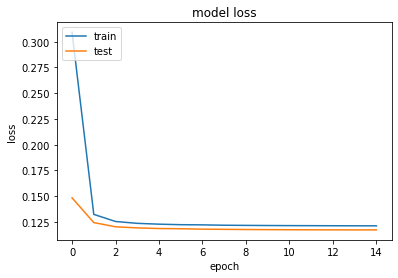

In [73]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
        
##############
# Functions to yield batches for the training
##############


def train_generator(self, batch_size):

    train_gen = InputBatchGenerator(self.X_train, self.y_train, batch_size, self.codes, self.sites, self.dim_msg)

    while True:
        try:
            for B in train_gen.generate_msg_count_batches():
                yield B
        except StopIteration:
            logging.warning("start over generator loop")          

def test_generator(self, batch_size):

    test_gen = InputBatchGenerator(self.X_test, self.y_test, batch_size, self.codes, self.sites, self.dim_msg)
    for B in test_gen.generate_msg_count_batches():
        yield B